In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import pandas as pd
import tensorflow as tf
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"


#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
application_df = application_df.drop(['EIN'], axis = 1)

In [3]:
cols = list(application_df.columns.values.tolist())

In [4]:
# Determine the number of unique values in each column.
application_df[cols].nunique()

NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [5]:
### Bin INCOME
income_amount_count = application_df["INCOME_AMT"].value_counts()
income_amount_count

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

<AxesSubplot:ylabel='Density'>

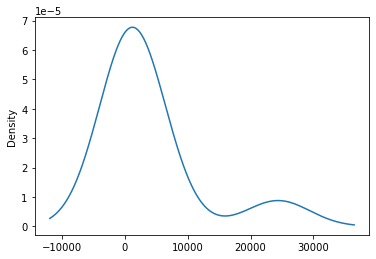

In [6]:
## Density Plot of Income
income_amount_count.plot.density()

In [7]:
# Determine which values to replace if counts are less than ...?
replace_income_amt = list(income_amount_count[income_amount_count <200].index)

# Replace in dataframe
for app in replace_income_amt:
    application_df['INCOME_AMT'] = application_df['INCOME_AMT'].replace(app,"Other")
    
# Check to make sure binning was successful
application_df['INCOME_AMT'].value_counts()

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
Other              324
10M-50M            240
Name: INCOME_AMT, dtype: int64

In [8]:
## Bin ORGANIZATION
organization_count = application_df['ORGANIZATION'].value_counts()
organization_count

Trust           23515
Association     10255
Co-operative      486
Corporation        43
Name: ORGANIZATION, dtype: int64

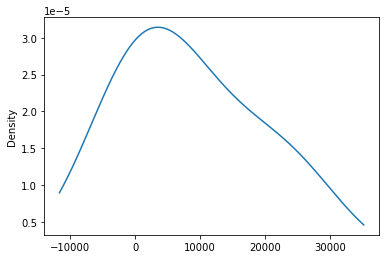

In [9]:
### Density Plot of Organization
organization_count.plot.density();

In [10]:
# Determine which values to replace if counts are less than ..?
replace_org = list(organization_count[organization_count <400].index)

# Replace in dataframe
for cls in replace_org:
    application_df['ORGANIZATION'] = application_df['ORGANIZATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
application_df['ORGANIZATION'].value_counts()

Trust           23515
Association     10255
Co-operative      486
Other              43
Name: ORGANIZATION, dtype: int64

In [11]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes =='object'].index.tolist()
application_cat

['NAME',
 'APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [12]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,NAME_1 DAY RANCH RESCUE AND RURAL OKLAHOMA ANIMAL RESOURCE INC,NAME_100 BLACK MEN OF AMERICA,NAME_100 BLACK MEN OF MEMPHIS INC,NAME_100 BLACK MEN OF WEST GEORGIA INC,NAME_1150 WEBSTER STREET INC,NAME_116TH CAVALRY REGIMENT CHAPTER OF THE US CAVALRY & ARMOR ASSOCIATION,NAME_13TH BOMB SQUADRON ASSOCIATION,NAME_146TH ALUMNI ASSOCIATION,NAME_14TH ARMORED DIVISION,NAME_150TH INTELLIGENCE SQUADRON ENLISTED ADVISORY COUNCIL,...,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_Other,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
application_df = application_df.merge(encode_df,left_index=True,right_index=True).drop(application_cat,1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,NAME_1 DAY RANCH RESCUE AND RURAL OKLAHOMA ANIMAL RESOURCE INC,NAME_100 BLACK MEN OF AMERICA,NAME_100 BLACK MEN OF MEMPHIS INC,NAME_100 BLACK MEN OF WEST GEORGIA INC,NAME_1150 WEBSTER STREET INC,NAME_116TH CAVALRY REGIMENT CHAPTER OF THE US CAVALRY & ARMOR ASSOCIATION,NAME_13TH BOMB SQUADRON ASSOCIATION,...,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_Other,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop(['IS_SUCCESSFUL','ASK_AMT'],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [15]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [16]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 100
hidden_nodes_layer2 = 75
hidden_nodes_layer3 = 20

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))


# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))


# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1968300   
_________________________________________________________________
dense_1 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1520      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,977,416
Trainable params: 1,977,416
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=1000)

In [18]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100, callbacks= cp_callback)

Epoch 1/100
804/804 [==============================] - 18s 21ms/step - loss: 0.5327 - accuracy: 0.7366
Epoch 2/100
193/804 [======>.......................] - ETA: 8s - loss: 0.1651 - accuracy: 0.9366
Epoch 00002: saving model to checkpoints/weights.02.hdf5
804/804 [==============================] - 12s 15ms/step - loss: 0.1430 - accuracy: 0.9472
Epoch 3/100
389/804 [=============>................] - ETA: 5s - loss: 0.0895 - accuracy: 0.9645
Epoch 00003: saving model to checkpoints/weights.03.hdf5
804/804 [==============================] - 11s 14ms/step - loss: 0.0919 - accuracy: 0.9633
Epoch 4/100
586/804 [====================>.........] - ETA: 3s - loss: 0.0852 - accuracy: 0.9653
Epoch 00004: saving model to checkpoints/weights.04.hdf5
804/804 [==============================] - 11s 14ms/step - loss: 0.0867 - accuracy: 0.9647
Epoch 5/100
781/804 [============================>.] - ETA: 0s - loss: 0.0901 - accuracy: 0.9642
Epoch 00005: saving model to checkpoints/weights.05.hdf5
804/804 

804/804 [==============================] - 11s 14ms/step - loss: 0.0754 - accuracy: 0.9686
Epoch 39/100
445/804 [===============>..............] - ETA: 4s - loss: 0.0741 - accuracy: 0.9701
Epoch 00039: saving model to checkpoints/weights.39.hdf5
804/804 [==============================] - 11s 14ms/step - loss: 0.0757 - accuracy: 0.9692
Epoch 40/100
643/804 [======================>.......] - ETA: 2s - loss: 0.0789 - accuracy: 0.9681
Epoch 00040: saving model to checkpoints/weights.40.hdf5
804/804 [==============================] - 11s 14ms/step - loss: 0.0793 - accuracy: 0.9680
Epoch 41/100
804/804 [==============================] - 11s 14ms/step - loss: 0.0822 - accuracy: 0.9666
Epoch 42/100
 33/804 [>.............................] - ETA: 10s - loss: 0.0641 - accuracy: 0.9748
Epoch 00042: saving model to checkpoints/weights.42.hdf5
804/804 [==============================] - 11s 14ms/step - loss: 0.0733 - accuracy: 0.9698
Epoch 43/100
229/804 [=======>......................] - ETA: 7s - 

804/804 [==============================] - 12s 15ms/step - loss: 0.0785 - accuracy: 0.9676
Epoch 76/100
699/804 [=========================>....] - ETA: 1s - loss: 0.0699 - accuracy: 0.9714
Epoch 00076: saving model to checkpoints/weights.76.hdf5
804/804 [==============================] - 12s 14ms/step - loss: 0.0705 - accuracy: 0.9712
Epoch 77/100
804/804 [==============================] - 11s 14ms/step - loss: 0.0773 - accuracy: 0.9684
Epoch 78/100
 92/804 [==>...........................] - ETA: 9s - loss: 0.1717 - accuracy: 0.9645
Epoch 00078: saving model to checkpoints/weights.78.hdf5
804/804 [==============================] - 11s 14ms/step - loss: 0.0919 - accuracy: 0.9681
Epoch 79/100
286/804 [=========>....................] - ETA: 7s - loss: 0.0787 - accuracy: 0.9669
Epoch 00079: saving model to checkpoints/weights.79.hdf5
804/804 [==============================] - 12s 14ms/step - loss: 0.0768 - accuracy: 0.9680
Epoch 80/100
484/804 [=================>............] - ETA: 4s - l

In [20]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 3s - loss: 0.7111 - accuracy: 0.6629
Loss: 0.7110916972160339, Accuracy: 0.6628571152687073


In [22]:
nn.save("AlphabetSoupCharity_Optimization1.h5")